In [4]:
pip install langchain-groq langchain_community tiktoken langchainhub chromadb langchain langgraph langchain_huggingface cassio arxiv wikipedia streamlit 

  Using cached tiktoken-0.8.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.6 kB)
Using cached tiktoken-0.8.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
import os 
import cassio
from pprint import pprint
from typing import List, Literal
from typing_extensions import TypedDict
import streamlit as st

from langchain.schema import Document

from langgraph.graph import END, StateGraph, START
from langchain_community.vectorstores import Chroma
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.pydantic_v1 import BaseModel, Field 
from langchain_core.prompts import ChatPromptTemplate
from langchain.vectorstores.cassandra import Cassandra
from langchain.indexes.vectorstore import VectorStoreIndexWrapper 
from langchain_groq import ChatGroq 
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings 
from langchain.vectorstores.cassandra import Cassandra


In [6]:
#########################################################
# Connecting to the ASTRA DB
#########################################################
ASTRA_DB_APPLICATION_TOKEN="AstraCS:fzZodIBfSJRpoXpLIZXLZpcN:d08cbc5bae62ac0d741be1924c0b30b72247fea7ccd7a4f45383e7272154f9d1" 
ASTRA_DB_ID="5eb44ca9-cce8-45f3-93e4-601bfe59c527"
cassio.init(token=ASTRA_DB_APPLICATION_TOKEN, database_id=ASTRA_DB_ID)


#########################################################
# GROQ API KEY 
######################################################### 
groq_api_key = "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"

In [7]:
########################################################
# Data loading and preprocessing
########################################################
def data_loading_preprocessing(urls):  
    # Load the dataset 
    docs = [WebBaseLoader(url).load() for url in urls]
    docs_list = [item for sublist in docs for item in sublist]
    # Split the dataset
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=500, chunk_overlap=0)
    doc_splits = text_splitter.split_documents(docs_list)
    return doc_splits 

# urls for reading the text
urls = [
    "https://www.salesforce.com/agentforce/what-are-ai-agents/#:~:text=AI%20agents%20are%20a%20type,a%20wide%20range%20of%20tasks.",
    "https://www.ibm.com/think/topics/artificial-intelligence",
    "https://www.cloudflare.com/learning/ai/what-is-large-language-model/",
] 
# Calling the function 
doc_splits = data_loading_preprocessing(urls) 

In [8]:

##########################################################
# Embedding and prepare VectorDB 
##########################################################
def embedding_and_store_data_to_vectorDB(doc_splits):
    # loading huggingface Embedding 
    embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2") 
    # cassandra vectorDB define 
    astra_vector_store=Cassandra(
        embedding=embeddings,
        table_name="qa_mini_demo",
        session=None,
        keyspace=None)
    astra_vector_store.add_documents(doc_splits)
    print("Inserted %i headlines." % len(doc_splits)) 

    return astra_vector_store

# calling the function 
astra_vector_store = embedding_and_store_data_to_vectorDB(doc_splits)

astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)
retriever = astra_vector_store.as_retriever()

# Checking is vectorDB working or not 
retriever.invoke("What is agent",ConsistencyLevel="LOCAL_ONE")


/home/hasan/liberate_labs_assignment/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Inserted 88 headlines.


[Document(id='4bd6c229555847ff8d65bb20e424e77a', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context lear

In [9]:
###########################################################
# Create Router, LLM Model selection, PromptTemplate, 
###########################################################
def Route_LLM_Model_PromptTemplate():
    class RouteQuery(BaseModel):
        """Route a user query to the most relevant datasource."""
        datasource: Literal["vectorstore", "wiki_search"] = Field(
            ...,
            description="Given a user question choose to route it to wikipedia or a vectorstore.",)

    # LLM model selection and Router connection 
    llm=ChatGroq(groq_api_key=groq_api_key, model_name="Gemma2-9b-It")
    structured_llm_router = llm.with_structured_output(RouteQuery)

    # Define Prompt
    system = """You are an expert at routing a user question to a vectorstore or wikipedia.
    The vectorstore contains documents related to competitor, investor, retail business.
    Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""
    route_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "{question}"),
        ]
    )

    question_router = route_prompt | structured_llm_router

    return question_router

# calling the function
question_router = Route_LLM_Model_PromptTemplate()

In [10]:
#################################################################
# Checking Wiki Search 
#################################################################
print(
    question_router.invoke(
        {"question": "who is Sharukh Khan?"}
    )
)

#################################################################
# Checking Vector Database  
#################################################################
print(
    question_router.invoke(
        {"question": "What are the types of agent memory?"}
    )
)

datasource='wiki_search'
datasource='vectorstore'


In [11]:
#########################################################
# Defining Arxiv and wikipedia Tools
#########################################################
def Arxiv_and_wikipedia_tools():
    arxiv_wrapper=ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=200)
    arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper)

    api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
    wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

    return arxiv, wiki 

arxiv, wiki = Arxiv_and_wikipedia_tools()

In [12]:
#########################################################
# Define Graph State
#########################################################
class GraphState(TypedDict):
    question: str
    generation: str
    documents: List[str]

#########################################################
# Define Retrieve
#########################################################
def retrieve(state):
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

In [13]:
#################################################
# Define Wiki search 
#################################################
def wiki_search(state):
    print("---wikipedia---")
    print("---HELLO--")
    question = state["question"]
    print(question)

    # Wiki search
    docs = wiki.invoke({"query": question})
    #print(docs["summary"])
    wiki_results = docs
    wiki_results = Document(page_content=wiki_results)

    return {"documents": wiki_results, "question": question}


#####################################################
# Define Edges 
#####################################################
def route_question(state):
    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"
    
 

In [14]:
#####################################################################
# Define StateGraph and add the node 
#####################################################################
workflow = StateGraph(GraphState)
# Define the nodes
workflow.add_node("wiki_search", wiki_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge( "retrieve", END)
workflow.add_edge( "wiki_search", END)
# Compile
app = workflow.compile()

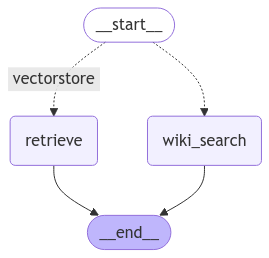

In [15]:
#####################################################################
# Display Node/Agent 
#####################################################################
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [19]:
#######################################################################
# 1st Prediction
#######################################################################
inputs = {
    "question": "What is AI Agents?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'])

# [0].dict()['metadata']['description']

---ROUTE QUESTION---
---ROUTE QUESTION TO Wiki SEARCH---
---wikipedia---
---HELLO--
What is AI Agents?
"Node 'wiki_search':"
'\n---\n'
Document(metadata={}, page_content='Page: Intelligent agent\nSummary: In intelligence and artificial intelligence, an intelligent agent (IA) is an agent that perceives its environment, takes actions autonomously in order to achieve goals')


In [20]:
##########################################################################
# 2nd Prediction 
##########################################################################
inputs = {
    "question": "About Bangladesh?"
} 
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'])

---ROUTE QUESTION---
---ROUTE QUESTION TO Wiki SEARCH---
---wikipedia---
---HELLO--
About Bangladesh?
"Node 'wiki_search':"
'\n---\n'
Document(metadata={}, page_content="Page: Bangladesh\nSummary: Bangladesh, officially the People's Republic of Bangladesh, is a country in South Asia. It is the eighth-most populous country in the world and seventh most densely populated")
